In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torchvision import  datasets
from torchvision.transforms import transforms


In [2]:
batch_size = 1
lr = 0.00001
weight_decay = 0.00005
epoch = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_tf = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='\MNIST_data', train=True, transform=data_tf, download=False)
test_dataset = datasets.MNIST(root='\MNIST_data', train=False, transform=data_tf, download=False)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [10]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(start_dim=1)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*3*3,128),
            nn.Linear(128,64),
            nn.Linear(64,2)
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        self.decoder_lin = nn.Sequential(
            nn.Linear(2,64),
            nn.Linear(64,128),
            nn.Linear(128,32*3*3)
        )
    def forward(self, x):
        x = self.decoder_lin(x)
        decode = self.decoder(x)
        return decode
decoder1 = decoder()
decoder1.load_state_dict(torch.load('./kaggleautoencoder.pth'))

<All keys matched successfully>

In [18]:
x = np.random.uniform(-0.6,0.6,10)
y = np.random.uniform(-0.6,0.6,10)

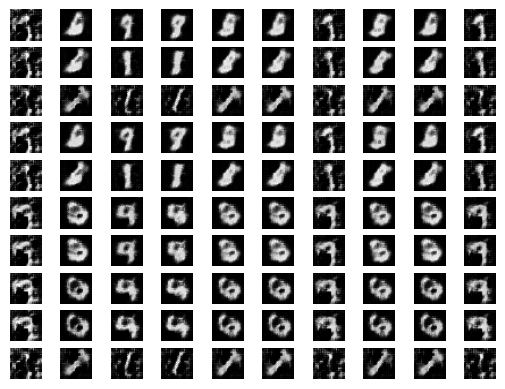

In [19]:
k = 1
with torch.no_grad():
    for i in x:
        for j in y:
            h = np.array([[i, j]],dtype=np.float32)
            a = decoder1(torch.from_numpy(h))
            plt.subplot(10,10,k)
            plt.imshow(a[0][0],cmap='gist_gray')
            plt.axis(False)
            k+=1
    plt.show()

In [13]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(start_dim=1)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*3*3,128),
            nn.Linear(128,64),
            nn.Linear(64,2)
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        self.decoder_lin = nn.Sequential(
            nn.Linear(2,64),
            nn.Linear(64,128),
            nn.Linear(128,32*3*3)
        )
    def forward(self, x):
        x = self.encoder(x)
        encode = self.encoder_lin(x)
        x = self.decoder_lin(encode)
        decode = self.decoder(x)
        return encode, decode
    
criterion = nn.BCELoss()
# 实例化一个模型，并迁移至gpu
model = autoencoder().to(device)
model.load_state_dict(torch.load('./kaggleautoencoder.pth'))
optimizier = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
print(model)

In [45]:
model.train()
for i in range(epoch):
    for img, label in train_loader:
        img = img.to(device)
        # forward
        _, output = model(img)
        loss = criterion(output,img)
        # backward
        optimizier.zero_grad()
        loss.backward()
        optimizier.step()
    if (i+1) % 5 == 0:
        print("epoch: {}, loss is {:.4f}".format((i+1), loss.data))
torch.save(model.state_dict(), './autoencoder_test.pth')

KeyboardInterrupt: 

In [14]:
model.eval()
lc = []
with torch.no_grad():
    for img, _ in train_loader:
        img = img.to(device)
        # forward
        _, output = model(img)
        lc.append(np.array(_.to('cpu')))

In [15]:
lc = np.array(lc).reshape([2,60000])

In [16]:
labels = np.array(train_dataset.targets)

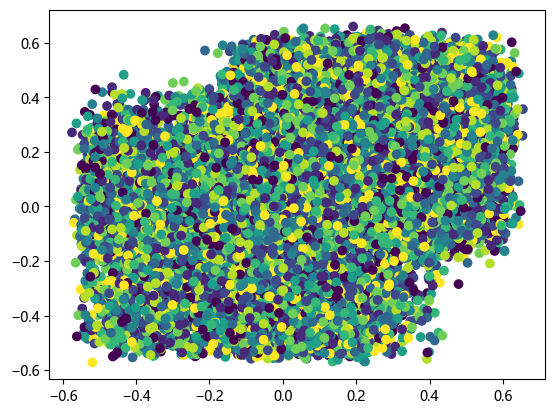

In [17]:
plt.scatter(lc[0],lc[1],c=labels)
plt.show()